
# Perform Customer Clustering for CG based on user portrait and corresponding transactions


In [1]:
# -*- coding: utf-8 -*-
import sys, getopt
import pandas as pd
import datetime
import os
import Tkinter, tkFileDialog
import numpy as np

## Data Wrangling

Load the data

In [2]:
NOW = datetime.date.today()
inputfile = '/Users/ito/venv/CG-RecoEng/data/og_data/Sales_Transaction.csv'
orders = pd.read_csv(inputfile, sep=',', engine='c', parse_dates=['TransactionDate'])
orders.shape

(3185518, 12)

In [3]:
productfile = '/Users/ito/venv/CG-RecoEng/data/og_data/ProductMaster_Tops.csv'
product = pd.read_csv(productfile, sep=',', engine='c')
product.head(2)

,BUID,SKUID,PRODUCT_ENG_DESC,DEPT_ID,DEPT_ENG_DESC,SUBDEPT_ID,SUBDEPT_ENG_DESC,CLASS_ID,CLASS_ENG_DESC,CAT_ID,CAT_ENG_DESC,SUBCAT_ID,SUBCAT_ENG_DESC,BRAND_CODE,BRAND_ENG_NAME,SUPPLIER_CODE,SUPPLIER_ENG_NAME
0,150,8851984131769,Autoquip Takara Springe(C2,3,GM/Housewares,5,GM/Non FMCG,1,DIY/Non FMCG,2,Garden Accessories/Non FMCG,1,Gardening Tools,10703,AUTO QUIP,9811566,"AUTO QUIP LTD.,PART"
1,150,8851984131837,Autoquip Takara Roll Jasmin(C2,3,GM/Housewares,5,GM/Non FMCG,1,DIY/Non FMCG,2,Garden Accessories/Non FMCG,1,Gardening Tools,10703,AUTO QUIP,9811566,"AUTO QUIP LTD.,PART"


In [4]:
orders.head(2)

,TypeGroup,BUID,BranchID,TransactionDate,CustomerID,CardNo,TicketNumber,SKUCode,Spending,DeptCode,SubDeptCode,QTY
0,1,1,175,2017-01-04 18:53:00,B794153F-943C-4181-A73D-22899BEC5DED,8041474156,404089732,4423513,350.0,600.0,601.0,1
1,1,1,5,2017-01-08 12:49:00,7451F1CB-4686-4D5F-8CB3-9E747B575A6F,8013455916,211318750,3415920,1473.0,200.0,205.0,1


From the discussion with Joc, we fix Tops data as the data for the demo.

Reason: in the detailed information "ProductMaster_Tops.csv" that given to us, all the products are in details rather than category info (i.e., "ProductMaster.csv") -- which is good for our data analysis (e.g., item of interest, item of recommendation).

Hence, we set Tops_trans_df as the data frame of the grocery data for this demo.

In [5]:
# Data Segmentation for Tops
Tops_trans_df = orders[orders.SKUCode.isin(product.SKUID)]
unique_Tops_trans_SKUID = Tops_trans_df.SKUCode.drop_duplicates()
sys.stderr.write('Among all ' + str(len(Tops_trans_df)) + ' items, there are ' + str(len(unique_Tops_trans_SKUID)) + ' unique items.') 

Among all 1995491 items, there are 44057 unique items.

In [6]:
Tops_trans_df.head(2)

,TypeGroup,BUID,BranchID,TransactionDate,CustomerID,CardNo,TicketNumber,SKUCode,Spending,DeptCode,SubDeptCode,QTY
7360,1,150,4294,2017-02-27 20:12:00,312CB58B-09B6-49CA-9F1D-AEF8D56E3F4E,8035450104,40155510,8851954101211,17.00,1.0,3.0,1
7361,1,150,2865,2017-01-18 12:28:00,35FFAE65-80FA-4A2B-8F05-98ACAE82EF86,8028520371,80176812,8851717901607,100.39,1.0,4.0,2


In [7]:
unique_Tops_trans_SKUID.sort_values().to_csv('SKUcode.csv', index = False)
sys.stderr.write("File created successfully for 'SKUcode.csv'")

File created successfully for 'SKUcode.csv'

## Data Cleansing
### Product Profiles

In [8]:
purchased_product = product[product.SKUID.isin(unique_Tops_trans_SKUID)]
purchased_product = purchased_product.sort_values(by='SKUID')

In [9]:
purchased_product.iloc[43345]

BUID                                                    150
SKUID                                         9414763002286
PRODUCT_ENG_DESC                     �Ѻ�Ҵ�ѭ�ת�ù��ʾ�����350�
DEPT_ID                                                   8
DEPT_ENG_DESC                        International Products
SUBDEPT_ID                                                2
SUBDEPT_ENG_DESC                             Inter Packaged
CLASS_ID                                                  4
CLASS_ENG_DESC                                       Health
CAT_ID                                                    5
CAT_ENG_DESC                                         Cereal
SUBCAT_ID                                                 3
SUBCAT_ENG_DESC                        Import Muesli Cereal
BRAND_CODE                                            13899
BRAND_ENG_NAME                                     HUBBARDS
SUPPLIER_CODE                                       9810803
SUPPLIER_ENG_NAME    CLASSIC FINE FOODS 

In [10]:
def data_clean_encoding_detection(input):
    try:
        input.encode()
        return input
    except UnicodeDecodeError:
        return 'Not Applicable'
    
purchased_product['PRODUCT_ENG_DESC'] = purchased_product.PRODUCT_ENG_DESC.map(data_clean_encoding_detection)  
purchased_product['BRAND_ENG_NAME'] = purchased_product.BRAND_ENG_NAME.map(data_clean_encoding_detection)  
purchased_product['SUPPLIER_ENG_NAME'] = purchased_product.SUPPLIER_ENG_NAME.map(data_clean_encoding_detection)  

In [11]:
# def data_clean_xa1(input):
#     if input.find('\xa1'):
#         input = input.replace('\xa1','_')
#     return input

# purchased_product[purchased_product.SKUID == 4901872441426].get_value(27633, 'PRODUCT_ENG_DESC').find('\xa1')
# purchased_product['PRODUCT_ENG_DESC'] = purchased_product.PRODUCT_ENG_DESC.map(data_clean_xa1)
# purchased_product.PRODUCT_ENG_DESC.replace('\xa1','_').get_value(27633, 'PRODUCT_ENG_DESC')

In [12]:
purchased_product.iloc[43345]

BUID                                                    150
SKUID                                         9414763002286
PRODUCT_ENG_DESC                             Not Applicable
DEPT_ID                                                   8
DEPT_ENG_DESC                        International Products
SUBDEPT_ID                                                2
SUBDEPT_ENG_DESC                             Inter Packaged
CLASS_ID                                                  4
CLASS_ENG_DESC                                       Health
CAT_ID                                                    5
CAT_ENG_DESC                                         Cereal
SUBCAT_ID                                                 3
SUBCAT_ENG_DESC                        Import Muesli Cereal
BRAND_CODE                                            13899
BRAND_ENG_NAME                                     HUBBARDS
SUPPLIER_CODE                                       9810803
SUPPLIER_ENG_NAME    CLASSIC FINE FOODS 

In [13]:
purchased_product.to_csv('Tops_of_interested.csv', index = False)

### Customer Profiles

In [14]:
cstmfile = '/Users/ito/venv/CG-RecoEng/data/og_data/Customer_Profile.csv'
customer = pd.read_csv(cstmfile, sep=',', engine='c')

def strip_brace(input):
#     input = input.strip('{')
#     input = input.strip('}')
    return input[1:-1]
#     return input

customer.CustomerID = customer.CustomerID.map(strip_brace)

In [15]:
grouped_by_userID = Tops_trans_df.groupby('CustomerID')
customer.__len__() - grouped_by_userID.__len__()

sys.stderr.write('Means that, there are ' + str(customer.__len__() - grouped_by_userID.__len__()) + ' customers who never go to Tops until now.')

Means that, there are 796 customers who never go to Tops until now.

Hence we calculate the portrait for each customer.

## Creating the fields as the user portrait -- comprehensive feature engineering

In [16]:
Tops_trans_df['tDate2'] = pd.to_datetime(Tops_trans_df['TransactionDate']).dt.date
recency = grouped_by_userID.tDate2.agg({'recency': lambda x: (NOW - x.max()).days})

/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [17]:
spent = grouped_by_userID.Spending.agg({'total_spent': np.sum, 'avg_spent': np.mean, 'med_spent': np.median})

/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [18]:
spent_range = grouped_by_userID.Spending.agg({'spent_range': lambda x: x.max()- x.min()})

/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [19]:
frequency = grouped_by_userID.TicketNumber.agg({'frequency': lambda x: len(x)})

/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [20]:
quantities = grouped_by_userID.QTY.agg({'quantities': np.sum})

/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [21]:
from collections import Counter 
varieties = grouped_by_userID.SKUCode.agg({'varieties': lambda x: len(Counter(x))})

/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [22]:
valid = grouped_by_userID.Spending.agg({'valid_trans': np.count_nonzero})
refund = grouped_by_userID.Spending.agg({'refund': lambda x: len(x[x<0])})
# Counter(Tops_trans_df.Spending<0)[True]

/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/Users/ito/venv/CG-RecoEng/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [23]:
portrait_df = pd.concat([recency, spent, spent_range, quantities, varieties, frequency, valid, refund],join="inner",axis=1)
portrait_df.head(3)

,recency,total_spent,avg_spent,med_spent,spent_range,quantities,varieties,frequency,valid_trans,refund
CustomerID,,,,,,,,,,
0003B311-AEFF-494D-9AAD-9951FA5AC599,183,16554.28,88.054681,46.775,1677.05,217,160,188,184.0,1.0
0005861F-87C4-4CEB-80D4-61CFB8F34E47,187,3458.70,111.570968,76.000,340.00,33,30,31,31.0,0.0
000684B2-425D-4B3E-9F97-388B88C2A2AD,169,11432.30,178.629688,101.500,856.00,139,54,64,61.0,0.0


## Perform Customer Clustering
Data Normalization before training process -- Since the distance in sklearn's k-means is euclidean, while we should perform a similarity based clustering (e.g., cosine, PCC, etc.), hence the normalization will make the score of euclidean equalize to cosine -- so to perform similarity based clustering.

In [24]:
from sklearn.preprocessing import normalize

X = np.array(portrait_df)
normed_X = normalize(X, axis=0, norm='l1')
X = normed_X

Suggested by Joc, hereby an elbow method for #cluster selection is conducted. 

Firstly, initialize the plot env.

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# plt.plot()
# colors = ['b', 'g', 'r']
# markers = ['o', 'v', 's']

Perform k-means while tracking their avg clustering distortions.

The “elkan” variation is more efficient by using the triangle inequality.
And it doesn’t support sparse data -- which is good -- our data is dense :)

In [26]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn import metrics

distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, algorithm='elkan',init='k-means++').fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'cosine'), axis=1)) / X.shape[0])

Plot the elbow according to the distortions from k-means.

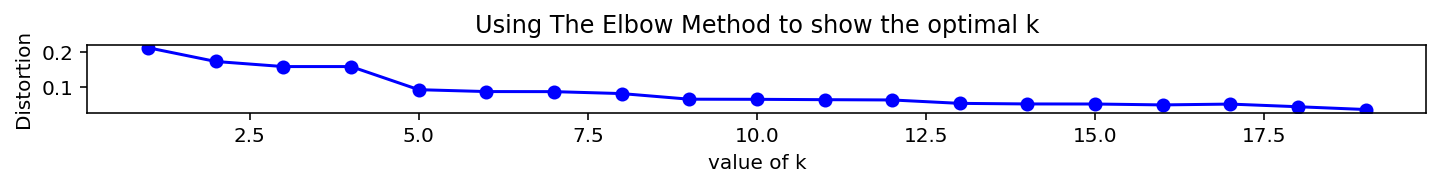

In [27]:
plt.plot(K, distortions, 'bo-')
plt.xlabel('value of k')
plt.ylabel('Distortion')
plt.title('Using The Elbow Method to show the optimal k')
plt.gcf().set_size_inches(12, 10*1.0/16)
plt.show()

At this stage, I would rather choose k = 5 for k, since 5, 6, 7.. share similar performance. Hence let's proceed to analyse when k = 5. 

Also we care about when k = 8.

In [28]:
# from sklearn.cluster import AffinityPropagation
# APModel = AffinityPropagation().fit(X)

## Clusters Analysis

In [29]:
K=5
kmeanModelfinal = KMeans(n_clusters=K, algorithm='elkan').fit(X)

See the number of customers in each cluster.

In [30]:
clusters = kmeanModelfinal.labels_.tolist()
clusters_dic = Counter(clusters)
pie_vec = [clusters_dic[i] for i in range(5)]
print pie_vec

[7799, 7, 25, 118, 1255]


A pie chart plot to visualize the %.

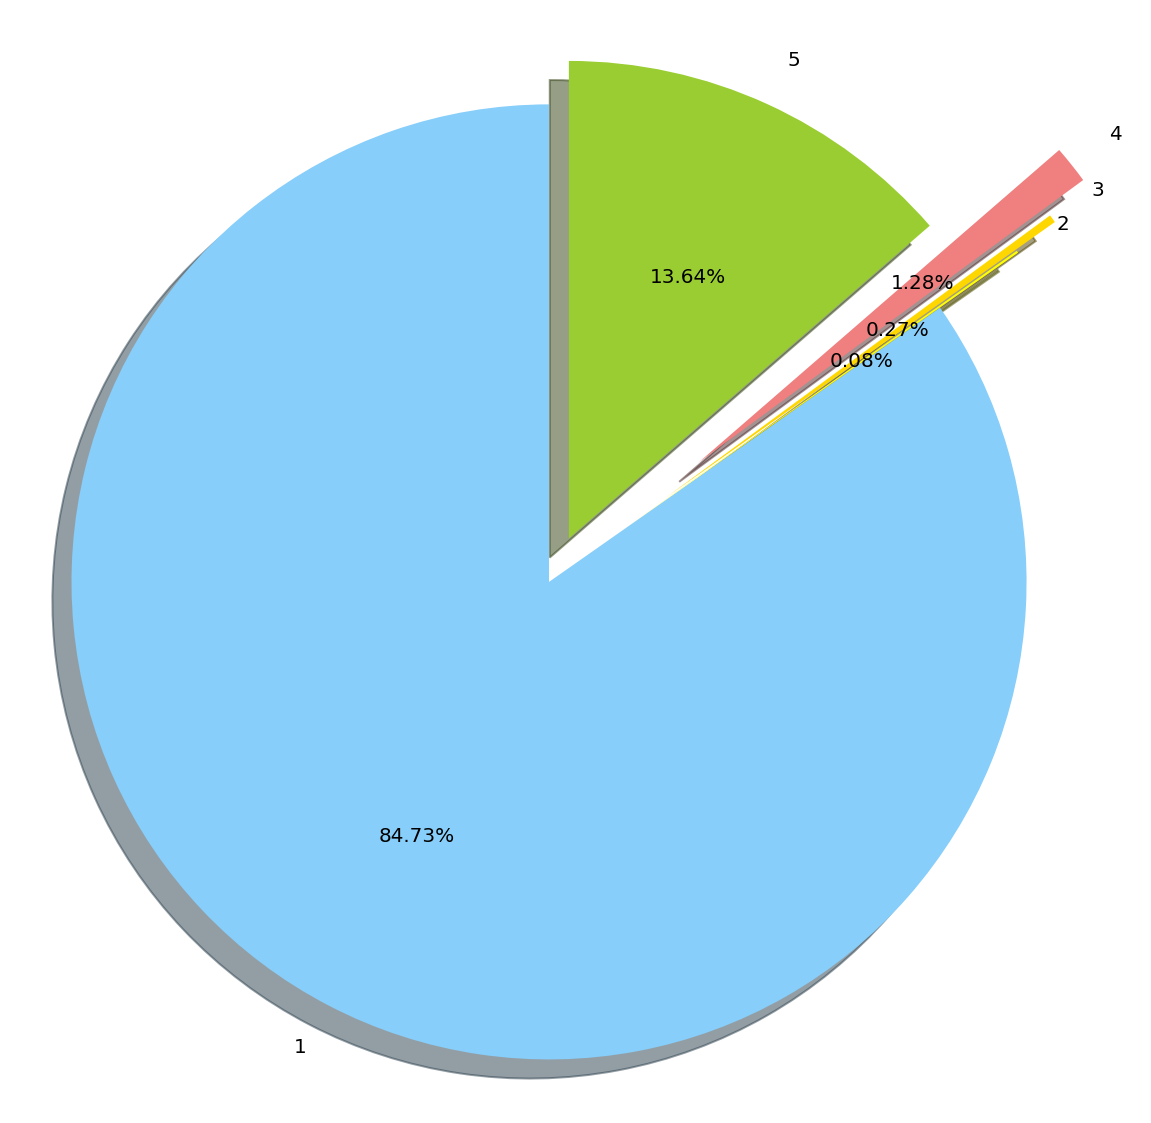

In [31]:
labels = ['1','2','3','4','5']
colors = ['lightskyblue', 'yellow', 'gold', 'lightcoral', 'yellowgreen']
explode = (0, 0.2, 0.3, 0.4, 0.1)
plt.pie(pie_vec, labels=labels, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
plt.gcf().set_size_inches(10, 10)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

In [32]:
cluster_df = pd.DataFrame(clusters)
cluster_df.index = portrait_df.index
frame = pd.concat([portrait_df, cluster_df], axis=1)

Change the column name for the clustering result.

In [33]:
frame_column_name = list(frame.columns)
frame_column_name[-1]='cluster'
frame.columns = frame_column_name

In [35]:
frame = frame.reset_index()
frame.head(2)

,index,CustomerID,recency,total_spent,avg_spent,med_spent,spent_range,quantities,varieties,frequency,valid_trans,refund,cluster
0,0,0003B311-AEFF-494D-9AAD-9951FA5AC599,183,16554.28,88.054681,46.775,1677.05,217,160,188,184.0,1.0,3
1,1,0005861F-87C4-4CEB-80D4-61CFB8F34E47,187,3458.70,111.570968,76.000,340.00,33,30,31,31.0,0.0,0


In [36]:
def days_to_year(input):
    try:
        return (NOW - input).days/365
    except:
        return 0
customer['BDay'] = pd.to_datetime(customer['DateofBirth']).dt.date
customer['Age'] = customer.BDay.map(days_to_year)

In [37]:
customer.head(2)

,CustomerID,DateofBirth,Nationality,Gender,MaritalStatus,NoofChildren,AgeofChildren,Province,Amphor,Tambon,...,CardRegisterBU,CardRegisterLocation,HaveOnlineaccount,CDS_Line,RBS_Line,IsMobilePhone,IsEmail,IsAddress,BDay,Age
0,25671A91-9FFB-4D38-A666-88352FB28BE6,1979-07-26 00:00:00,Thai,F,M,1,03,นนทบุรี,ปากเกร็ด,ท่าอิฐ,...,B2S,B2S RBS Ratanatibeth,Y,Y,N,Y,Y,Y,1979-07-26,38
1,B729BCAA-4201-4A6A-B187-1573CDDB90D4,1985-12-12 00:00:00,Thai,F,NaN,0,NaN,นนทบุรี,ปากเกร็ด,บางพูด,...,Office Depot,Phayathai,N,N,N,Y,Y,Y,1985-12-12,31


In [38]:
Tops_customer = customer[customer.CustomerID.isin(frame.CustomerID)][['CustomerID', "Nationality","Gender","MaritalStatus",'HaveOnlineaccount','Age']]
sorted_Tops_customer = Tops_customer.sort_values('CustomerID')

To better incorporate information, the customer csv file is hence combined with some useful fields.

In [39]:
# sorted_Tops_customer['CustomerIDR'] = sorted_Tops_customer.CustomerID
# sorted_Tops_customer.head(2)
big_frame = pd.merge(frame, sorted_Tops_customer, how='inner')
# ,left_on=frame.CustomerID, right_on=sorted_Tops_customer.CustomerIDR)

In [40]:
big_frame.head(2)

,index,CustomerID,recency,total_spent,avg_spent,med_spent,spent_range,quantities,varieties,frequency,valid_trans,refund,cluster,Nationality,Gender,MaritalStatus,HaveOnlineaccount,Age
0,0,0003B311-AEFF-494D-9AAD-9951FA5AC599,183,16554.28,88.054681,46.775,1677.05,217,160,188,184.0,1.0,3,Thai,F,S,Y,36
1,1,0005861F-87C4-4CEB-80D4-61CFB8F34E47,187,3458.70,111.570968,76.000,340.00,33,30,31,31.0,0.0,0,Unknown,NaN,NaN,N,39


### Group Labelling

With the customer clustered, a simple analysis can be hence carried out for an "automated" labelling of the corresponding group/cluster to better understand them. For a better illustration, I have turned different fields to similar [0, 1] scale where all the info can be gathered in one plot.

In [41]:
import math

def autolabel(rects): 
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/5., 0.025 + height, "%.2f" % float(height))
        
def autolabel_realvalue(rects, realvalues): 
    for idx, rect in enumerate(rects):
        height = rect.get_height()
        plt.text(rect.get_x(), 0.01 + height, "%.4s" % float(realvalues[idx])) #+rect.get_width()/5.
        
def return_log_list(list):
    return [math.log(list[i]) if list[i]>1 else 0 for i in range(len(list)) ]

def normalize_vec(vec):
    v_min, v_max = vec.min(), vec.max() 
    return (vec-v_min)/(v_max-v_min)  

def portionwise(vec):
    return vec / sum(vec)
#     return vec * 1.0 / sum(vec)

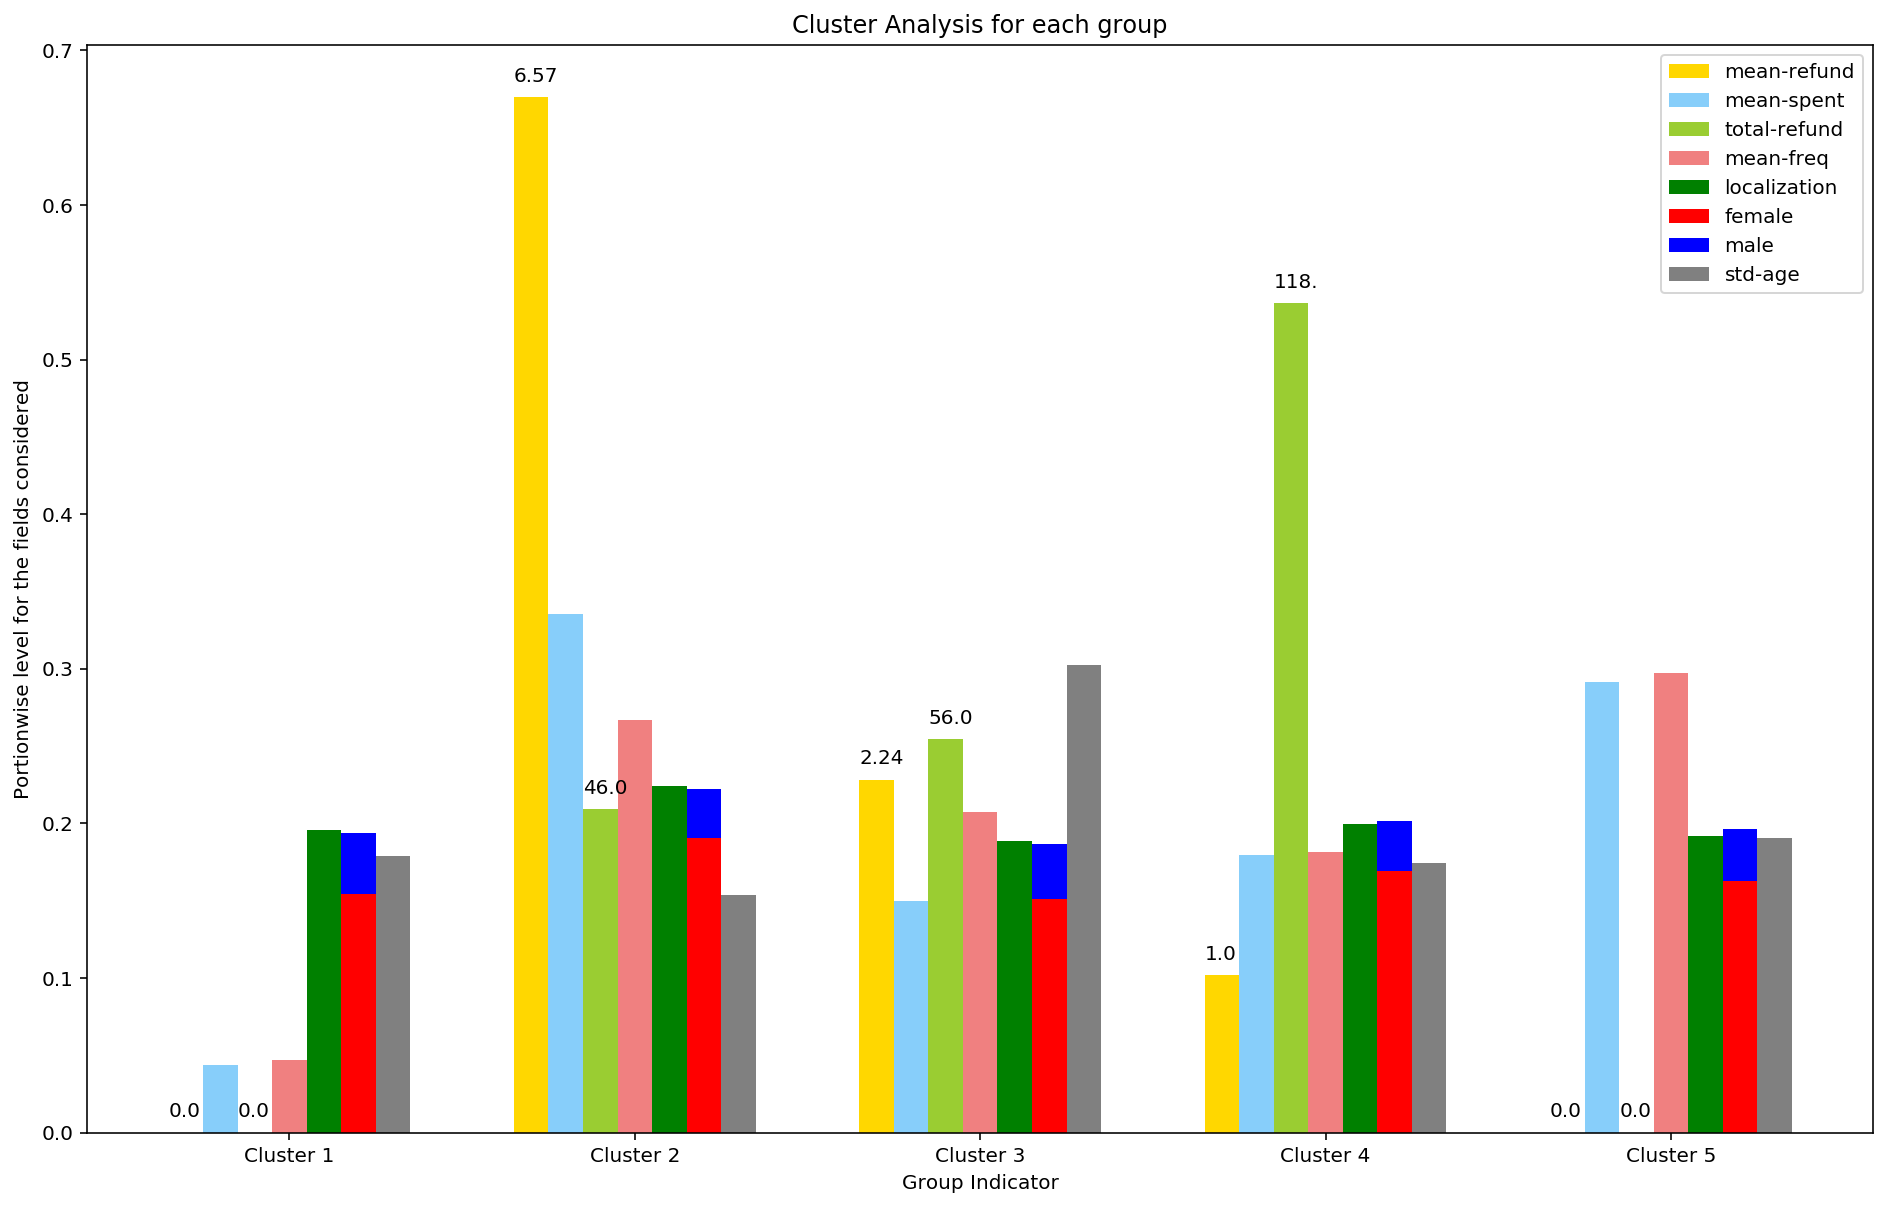

In [43]:
cluster_name_list = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']
# x =list(range(5)) 
x = np.arange(K)
total_width, n = 0.8, 8 
width = total_width / n  
x = x - (total_width - width) / 2

rects = plt.bar(x,portionwise(list(frame.groupby('cluster').refund.mean())),
                tick_label = cluster_name_list, color = 'gold', width=width, label = 'mean-refund',)
plt.title("Cluster Analysis for each group")

autolabel_realvalue(rects, frame.groupby('cluster').refund.mean())
# autolabel(rects)

rects_2 = plt.bar(x + width, portionwise(list(frame.groupby('cluster').total_spent.mean())),
                  tick_label = cluster_name_list, color = 'lightskyblue', width=width, label='mean-spent') 
# rects_2 = plt.bar(x, return_log_list(frame.groupby('cluster').total_spent.mean()),
#                   tick_label = cluster_name_list, color = 'lightskyblue', width=width, label='mean-spent') 
# autolabel(rects_2)

# for i in range(len(x)):  
#     x[i] = x[i] + width  
rects_2 = plt.bar(x + 2 * width, portionwise(list(frame.groupby('cluster').refund.sum())),
                  tick_label = cluster_name_list, color = 'yellowgreen', width=width, label='total-refund') 
# autolabel(rects_2)
autolabel_realvalue(rects_2, frame.groupby('cluster').refund.sum())

# for i in range(len(x)):  
#     x[i] = x[i] + width  
# rects_3 = plt.bar(x, return_log_list(frame.groupby('cluster').refund.count()),
#                   tick_label = cluster_name_list, color = 'lightcoral', width=width, label='#customer') 
rects_3 = plt.bar(x + 3 * width, portionwise(list(frame.groupby('cluster').frequency.mean())),
                  tick_label = cluster_name_list, color = 'lightcoral', width=width, label='mean-freq') 
# autolabel(rects_3)


# for i in range(len(x)):  
#     x[i] = x[i] + width
localization = list(big_frame.groupby('cluster').Nationality.agg({lambda x: list(x=='Thai').count(True) * 1.0 / len(x)})['<lambda>'])
rects_4 = plt.bar(x + 4 * width, portionwise(localization),
                  color = 'g', width=width, label='localization') 


male = list(big_frame.groupby('cluster').Gender.agg({lambda x: list(x=='M').count(True) * 1.0 / len(x)})['<lambda>'])
female = list(big_frame.groupby('cluster').Gender.agg({lambda x: list(x=='F').count(True) * 1.0 / len(x)})['<lambda>'])

available_gender = np.array(male) + np.array(female)
male_portion = np.array(male) / available_gender
female_portion = np.array(female) / available_gender
total_bar = portionwise(available_gender)
male_section = total_bar * male_portion
female_section = total_bar * female_portion

rects_5 = plt.bar(x + 5 * width, female_section, 
                  color = 'r', width=width, label='female') 
rects_6 = plt.bar(x + 5 * width, male_section,
                  bottom=female_section, color = 'b', width=width, label='male') 

# for i in range(len(x)):  
#     x[i] = x[i] + width
rects_7 = plt.bar(x + 6 * width, portionwise(big_frame.groupby('cluster').Age.std()),
                  color = 'grey', width=width, label='std-age') 


plt.xlabel("Group Indicator")
plt.ylabel("Portionwise level for the fields considered")

plt.legend()
plt.gcf().set_size_inches(16, 10)
plt.show()

### Figure above shows the cluster analysis -- the number above indicating the real value, while all of them are compressed into same scale (portionwise) for visualization only.

[7, 7799, 25, 118, 1255]


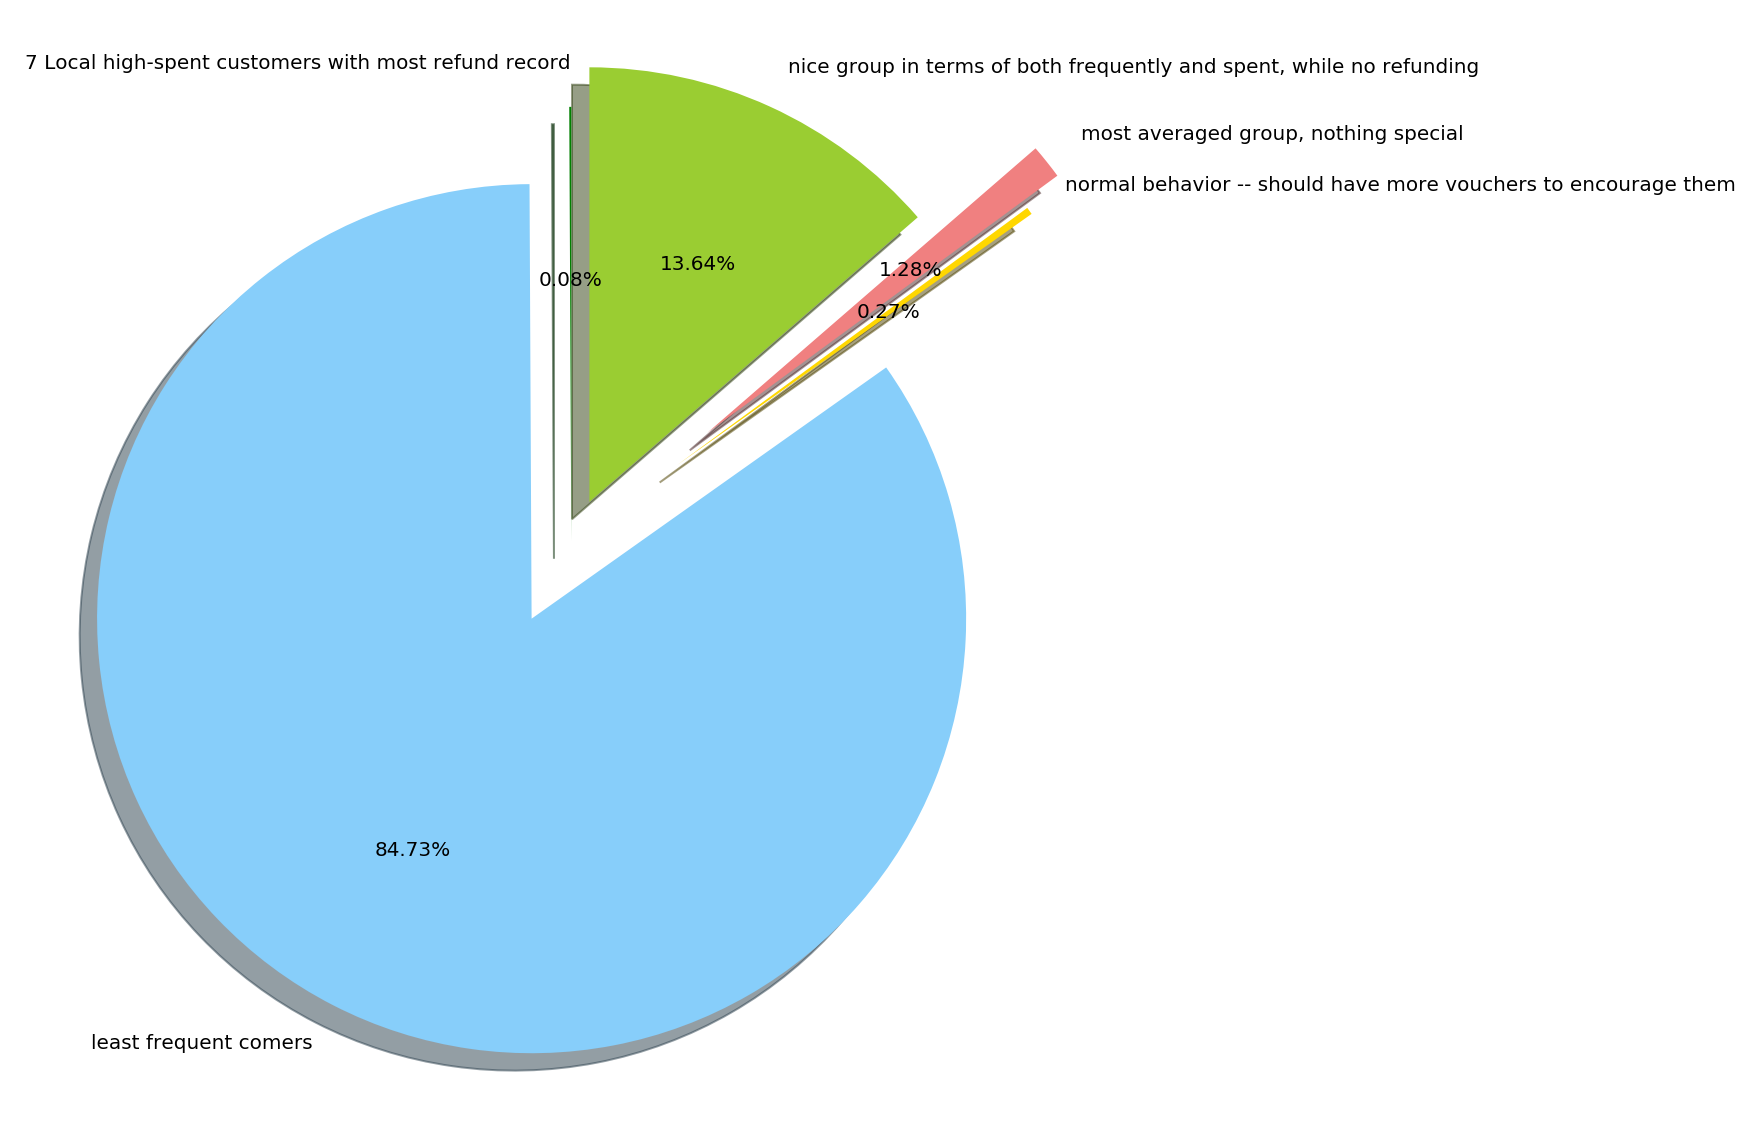

In [48]:
labels = ['least frequent comers',
          '7 Local high-spent customers with most refund record',
          'normal behavior -- should have more vouchers to encourage them',
          'most averaged group, nothing special',
          'nice group in terms of both frequently and spent, while no refunding']
colors = ['lightskyblue', 'green', 'gold', 'lightcoral', 'yellowgreen']

colors[1], colors[0] = colors[0], colors[1]
pie_vec[1], pie_vec[0] = pie_vec[0], pie_vec[1]
labels[1], labels[0] = labels[0], labels[1]

explode = (0, 0.2, 0.3, 0.4, 0.1)
plt.pie(pie_vec, labels=labels, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
plt.gcf().set_size_inches(10, 10)
print pie_vec
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

## Correlation Analysis
### The 'frequency', 'valid transaction' and 'varieties' are highly correlated -- means that: come more, shop more and pick more

In [587]:
# print normalize_vec(np.array(frame.groupby('cluster').valid_trans.mean()))
    
aa = list(frame.groupby('cluster').frequency.mean())
bb = list(frame.groupby('cluster').valid_trans.mean())
cc = list(frame.groupby('cluster').varieties.mean())
print np.corrcoef(aa,bb)[0,1]
print np.corrcoef(bb,cc)[0,1]
print np.corrcoef(aa,cc)[0,1]

0.999673146653
0.995508299617
0.994790846116


In [615]:
# print normalize_vec(np.array(frame.groupby('cluster').valid_trans.mean()))
    
aa = list(frame.groupby('cluster').total_spent.mean())
bb = list(frame.groupby('cluster').avg_spent.mean())
cc = list(frame.groupby('cluster').med_spent.mean())
print np.corrcoef(aa,bb)[0,1]
print np.corrcoef(bb,cc)[0,1]
print np.corrcoef(aa,cc)[0,1]

0.670218099552
0.967102125546
0.496952994989


In [565]:
frame.groupby('cluster').total_spent.mean()

cluster
0    102776.598709
1    118267.921429
2     63223.124322
3     52671.024800
4     15339.231616
Name: total_spent, dtype: float64

In [353]:
frame.groupby('cluster').refund.mean()

cluster
0    0.000000
1    6.571429
2    1.000000
3    2.240000
4    0.000000
Name: refund, dtype: float64

In [308]:
# for item in frame.groupby('cluster').refund.sum():
    

type(frame.groupby('cluster').refund.sum()[0])

numpy.float64

In [300]:
math.log(1.21)
# frame.groupby('cluster').refund.sum()

0.1906203596086497

### Observation: Current result is with some coarse characteristics for each run-out cluster, however, since the data is biased (as is already a class of customers), current observation is limited. In the near future, we will add hierarchical clustering on top to better define the behavior of customers. 

[6748, 5, 118, 12, 1970, 3, 24, 324]


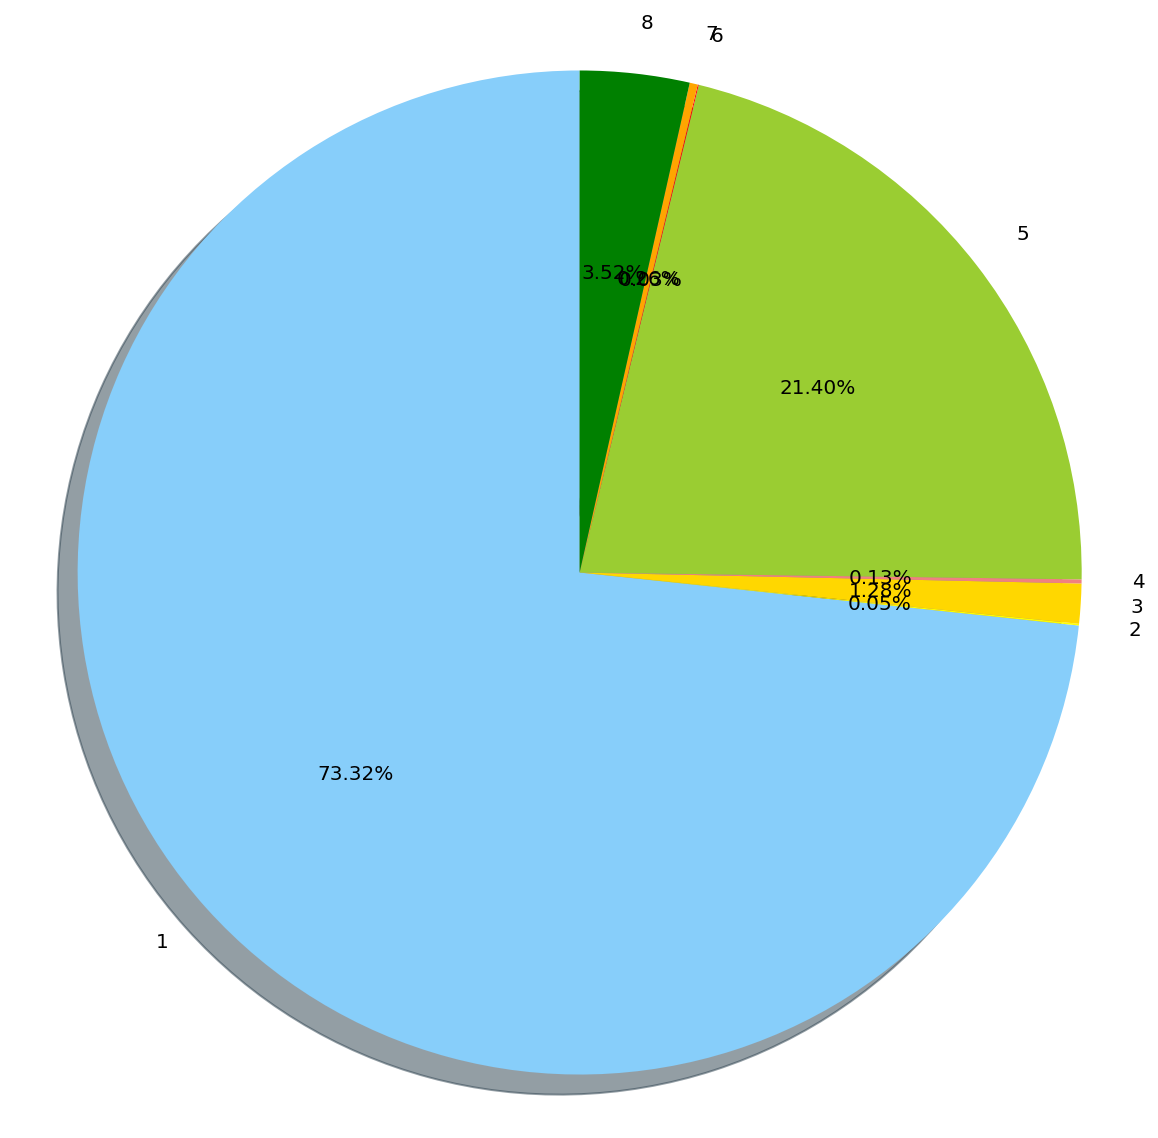

In [747]:
kmeanModelfinal_8 = KMeans(n_clusters=8, algorithm='elkan').fit(X)

clusters_8 = kmeanModelfinal_8.labels_.tolist()
clusters_dic_8 = Counter(clusters_8)
pie_vec_8 = [clusters_dic_8[i] for i in range(8)]
print pie_vec_8

labels = ['1','2','3','4','5','6','7','8']
colors = ['lightskyblue', 'yellow', 'gold', 'lightcoral', 'yellowgreen','red','orange','green','blue','black']
# explode = (0, 0.2, 0.3, 0.4, 0.1)
# explode=explode, 
plt.pie(pie_vec_8, labels=labels, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
plt.gcf().set_size_inches(10, 10)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

[6767, 3, 118, 315, 24, 53, 3, 4, 1912, 5]


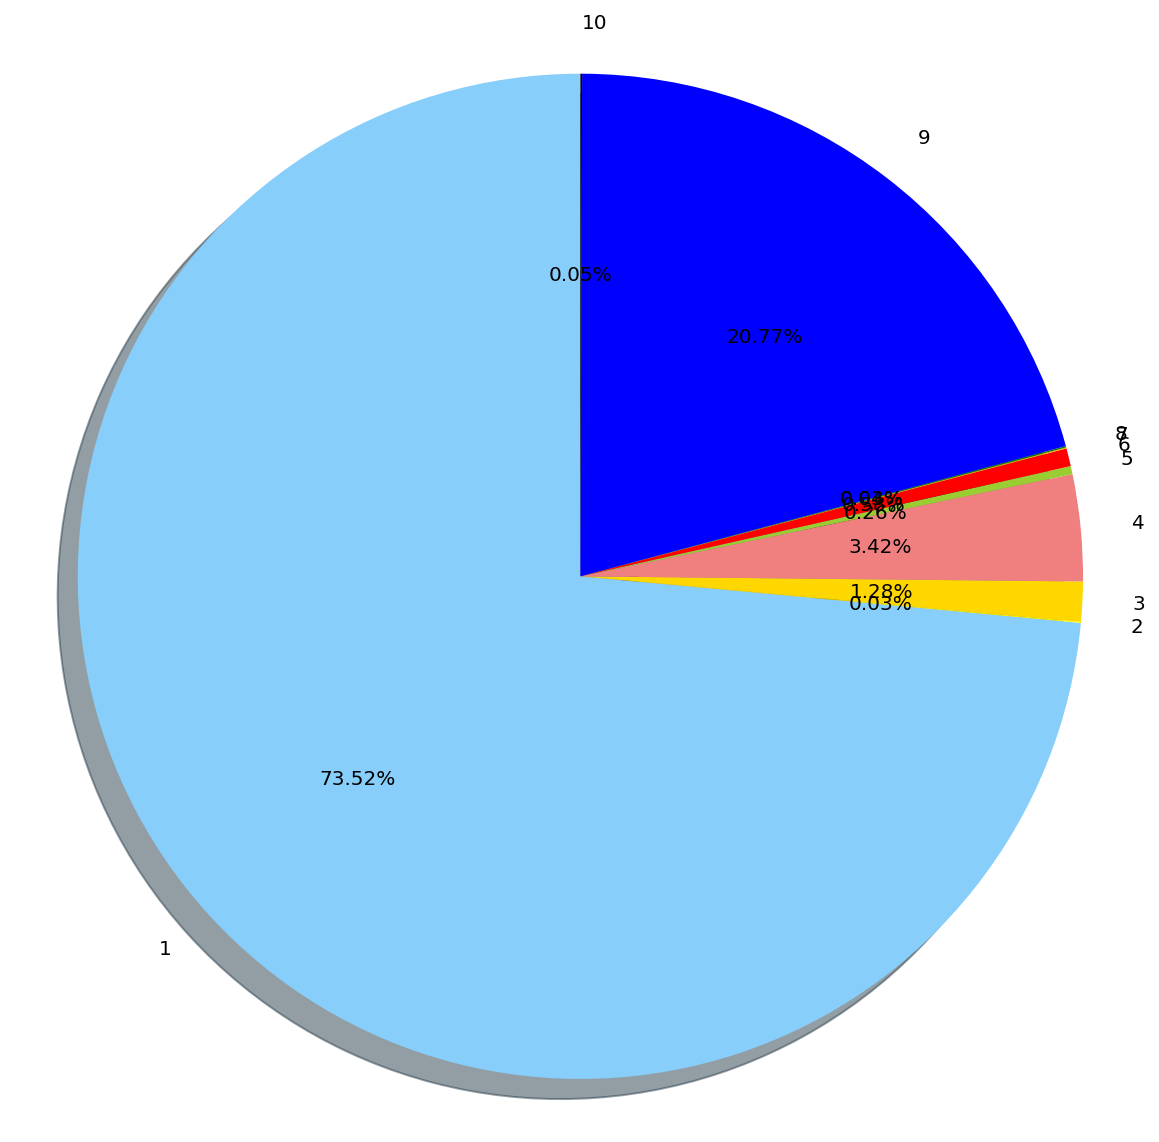

In [779]:
kmeanModelfinal_10 = KMeans(n_clusters=10, algorithm='elkan').fit(X)

clusters_10 = kmeanModelfinal_10.labels_.tolist()
clusters_dic_10 = Counter(clusters_10)
pie_vec_10 = [clusters_dic_10[i] for i in range(10)]
print pie_vec_10

labels = ['1','2','3','4','5','6','7','8','9','10']
colors = ['lightskyblue', 'yellow', 'gold', 'lightcoral', 'yellowgreen','red','orange','green','blue','black']
# explode = (0, 0.2, 0.3, 0.4, 0.1)
# explode=explode, 
plt.pie(pie_vec_10, labels=labels, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
plt.gcf().set_size_inches(10, 10)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

In [ ]:
[3128, 100, 2, 20, 30, 664, 3, 1, 1, 1049]

## Appendix 

### Data issue to be fixed on

In [749]:
big_frame.groupby('cluster').Age.min()

cluster
0     0
1    31
2     0
3     0
4   -31
Name: Age, dtype: int64

Check when the customer IDs are matched -- 
previously solving the case that "big_frame = pd.merge(frame, sorted_Tops_customer, how='inner',                     left_on=frame.index, right_on=sorted_Tops_customer.CustomerID)" is not working.

In [490]:
def examine_str_match(input1, input2):
    if input1 == input2:
        return 0
    else:
        return 1
    
if sum([examine_str_match(each, sorted_Tops_customer.iloc[idx].CustomerID) for idx, each in enumerate(frame.index)]) == 0:
    print 'test passed'


Plot two stuff on the same page.

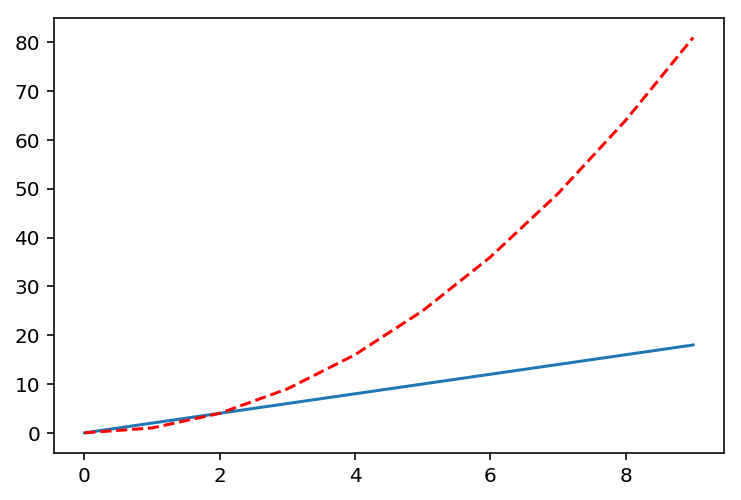

In [331]:
import matplotlib.pyplot as plt

x = range(10)
y1 = [elem*2 for elem in x]
plt.plot(x, y1)

y2 = [elem**2 for elem in x]
plt.plot(x, y2, 'r--')

plt.show()

Just to prove that Agglomerative Clustering is not working on this data set.

In [696]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T

In [706]:
# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)
sum(sum(knn_graph.nonzero()))*1.0/1500/1500

29.965277777777775

An example to visualize “Agglomerative clustering with and without structure”

In [ ]:
for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average', 'complete', 'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_,
                        cmap=plt.cm.spectral)
            plt.title('linkage=%s (time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()

### For James' enquery on nationalities

In [545]:
len(big_frame[big_frame.Nationality == 'Russian'])

24

In [548]:
len(big_frame[big_frame.Nationality == 'Thai'])

8002

In [547]:
len(Counter(big_frame.Nationality))

52

In [549]:
Counter(big_frame.Nationality)

Counter({'Afghan': 1,
         'American': 8,
         'Australian': 9,
         'Bangladeshi': 4,
         'Belgian': 1,
         'Bhutanese': 1,
         'Brazilian': 1,
         'British': 19,
         'Burmese': 11,
         'Cambodian': 19,
         'Canadian': 4,
         'Chilean': 2,
         'Chinese': 43,
         'Congolese': 1,
         'Czech': 1,
         'Danish': 1,
         'Dutch': 1,
         'Egyptian': 1,
         'Ethiopian': 1,
         'Filipino': 11,
         'French': 10,
         'German': 4,
         'Guinean': 2,
         'HONG KONG': 2,
         'Indian': 37,
         'Indonesian': 3,
         'Iranian': 1,
         'Irish': 1,
         'Israeli': 3,
         'Italian': 2,
         'Japanese': 12,
         'Laotian': 13,
         'Malaysian': 7,
         'Maldivan': 1,
         'NETHERLANDS ANTILLES': 1,
         'NEW ZEALAND': 2,
         'Nepalese': 1,
         'North Korean': 1,
         'Pakistani': 3,
         'Russian': 24,
         'Singaporean': 10

In [513]:
print frame.groupby('cluster').total_spent.mean()
print (frame.groupby('cluster').total_spent.std())

frame.groupby('cluster').refund.sum()
return_log_list(frame.groupby('cluster').total_spent.std())


cluster
0    102776.598709
1    118267.921429
2     63223.124322
3     52671.024800
4     15339.231616
Name: total_spent, dtype: float64
cluster
0     72860.829309
1    117677.270131
2     72856.884483
3     42168.873261
4     15096.688242
Name: total_spent, dtype: float64


[11.19630645272196,
 11.675701157617626,
 11.196252309322281,
 10.649437627423227,
 9.622230677008023]